# Table Of Contents

- [0. Introduction](#0)
- [1. Importing the libraries](#1)
- [2. Visualizing the data randomly](#2)
- [3. Cropping the useful info and labeling them](#4)
- [4. Converting the feature list to np array](#4)
- [5. Visualizing the cropped images](#5)
- [6. One-hot Encode the labels](#6)
    - [6.1 Split the data into test, train and validation sets](#6.1)
- [7. Normalization](#7)
- [8. Define the VGG-19 model architecture](#8)
- [9. Compile the Model](#9)
- [10. Augmenting the Images](#10)
- [11. Train the Model](#11)
- [12. Load the Model with the Best Validation Accuracy](#12)
- [13. Calculate Classification Accuracy on Test Set](#13)

# 1. Importing the libraries<a class="anchor" id="1"></a>

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import os
import xml.etree.ElementTree as ET
from PIL import Image 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
breed_list = os.listdir('Annotation/') # list of all breeds for further demo

# 2. Visualizing the data randomly<a class="anchor" id="2"></a>

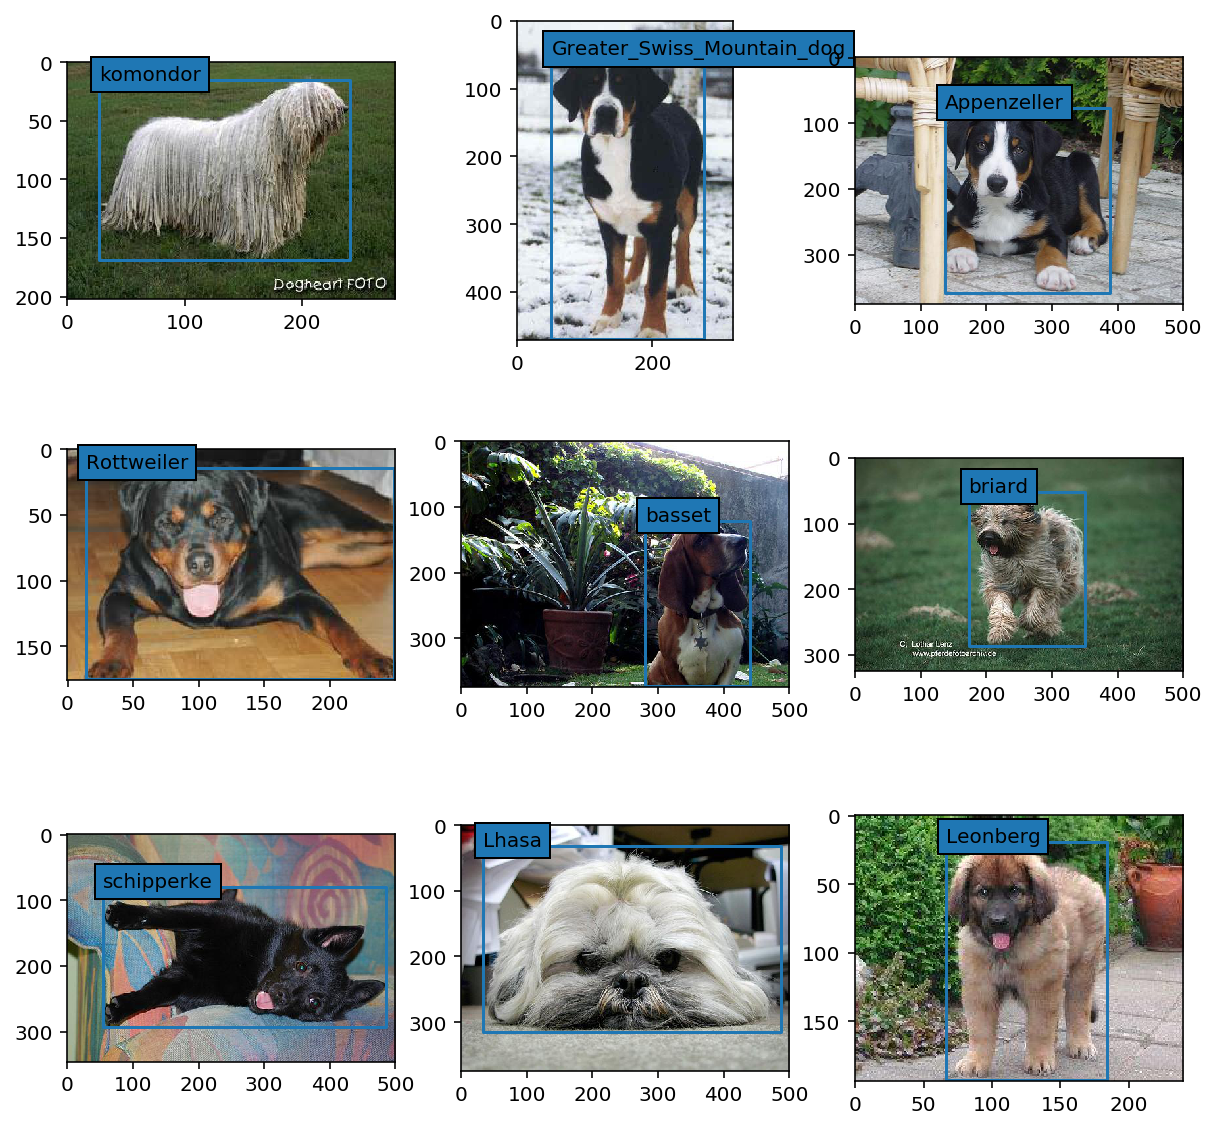

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # showing 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('Annotation/' + breed)) # random image 
    img = Image.open('Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() # idk what's it but it's from documentation
    objects = root.findall('object') # finding all dogs. An array
    plt.imshow(img) # displays photo
    for o in objects:
        bndbox = o.find('bndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) # printing breed

# 3. Cropping the useful info and labeling them<a class="anchor" id="3"></a>

- Crop only the bounding boxes
- Use the cropped image as data set instead of original data set

In [8]:
import collections
!pip install opencv-python
import cv2
#df_dict = collections.defaultdict(list)
x_train = []
y_train = []
for breed in breed_list:
    print("breed: ", breed)
    try :
        images = os.listdir('Images/' + breed)
    except:
        continue
    
    for image in images:
        imgg =  plt.imread('Images/' + breed + '/' + image)
        tree = ET.parse('Annotation/' + breed+'/' + image[:-4]) # init parser for file given
        root = tree.getroot() # idk what's it but it's from documentation
        objects = root.findall('object') # finding all dogs. An array
        for o in objects:
            bndbox = o.find('bndbox') # reading border coordinates
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            img = imgg[ymin:ymin+ymax , xmin:xmin+xmax, :]
            img = cv2.resize(img,(150,150))
            x_train.append(np.array(img))
            y_train.append(o.find('name').text)

  Using cached https://files.pythonhosted.org/packages/77/30/36c3f0644fa9f42d92f079b972e990a5874c1fc2b2c0e9656eb88bb8d6dc/opencv_python-4.1.0.25-cp27-cp27mu-manylinux1_x86_64.whl
Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/pip/basecommand.py", line 215, in main
    status = self.run(options, args)
  File "/usr/local/lib/python2.7/dist-packages/pip/commands/install.py", line 342, in run
    prefix=options.prefix_path,
  File "/usr/local/lib/python2.7/dist-packages/pip/req/req_set.py", line 784, in install
    **kwargs
  File "/usr/local/lib/python2.7/dist-packages/pip/req/req_install.py", line 851, in install
    self.move_wheel_files(self.source_dir, root=root, prefix=prefix)
  File "/usr/local/lib/python2.7/dist-packages/pip/req/req_install.py", line 1064, in move_wheel_files
    isolated=self.isolated,
  File "/usr/local/lib/python2.7/dist-packages/pip/wheel.py", line 345, in move_wheel_files
    clobber(source, lib_dir, True)
  File "

# 4. Converting the feature list to np array<a class="anchor" id="4"></a>

In [9]:
for index, element in enumerate(x_train):
    if element.shape != (150, 150, 3):
        x_train.remove(element)
        del(y_train[index])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
x_train = np.array(x_train)

# 5. Visualizing the cropped images<a class="anchor" id="5"></a>

In [11]:
def visualize_images(df, img_size, number_of_images):
    plt.figure(figsize=(16,16))
    n_rows = df.shape[0]
    #reshaped_df = df.reshape(df.shape[0], img_size, img_size)
    number_of_rows = number_of_images/5 if number_of_images%5 == 0 else (number_of_images/5) +1
    for i in range(number_of_images):
        plt.subplot(number_of_rows, 5, i+1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(df[i]))

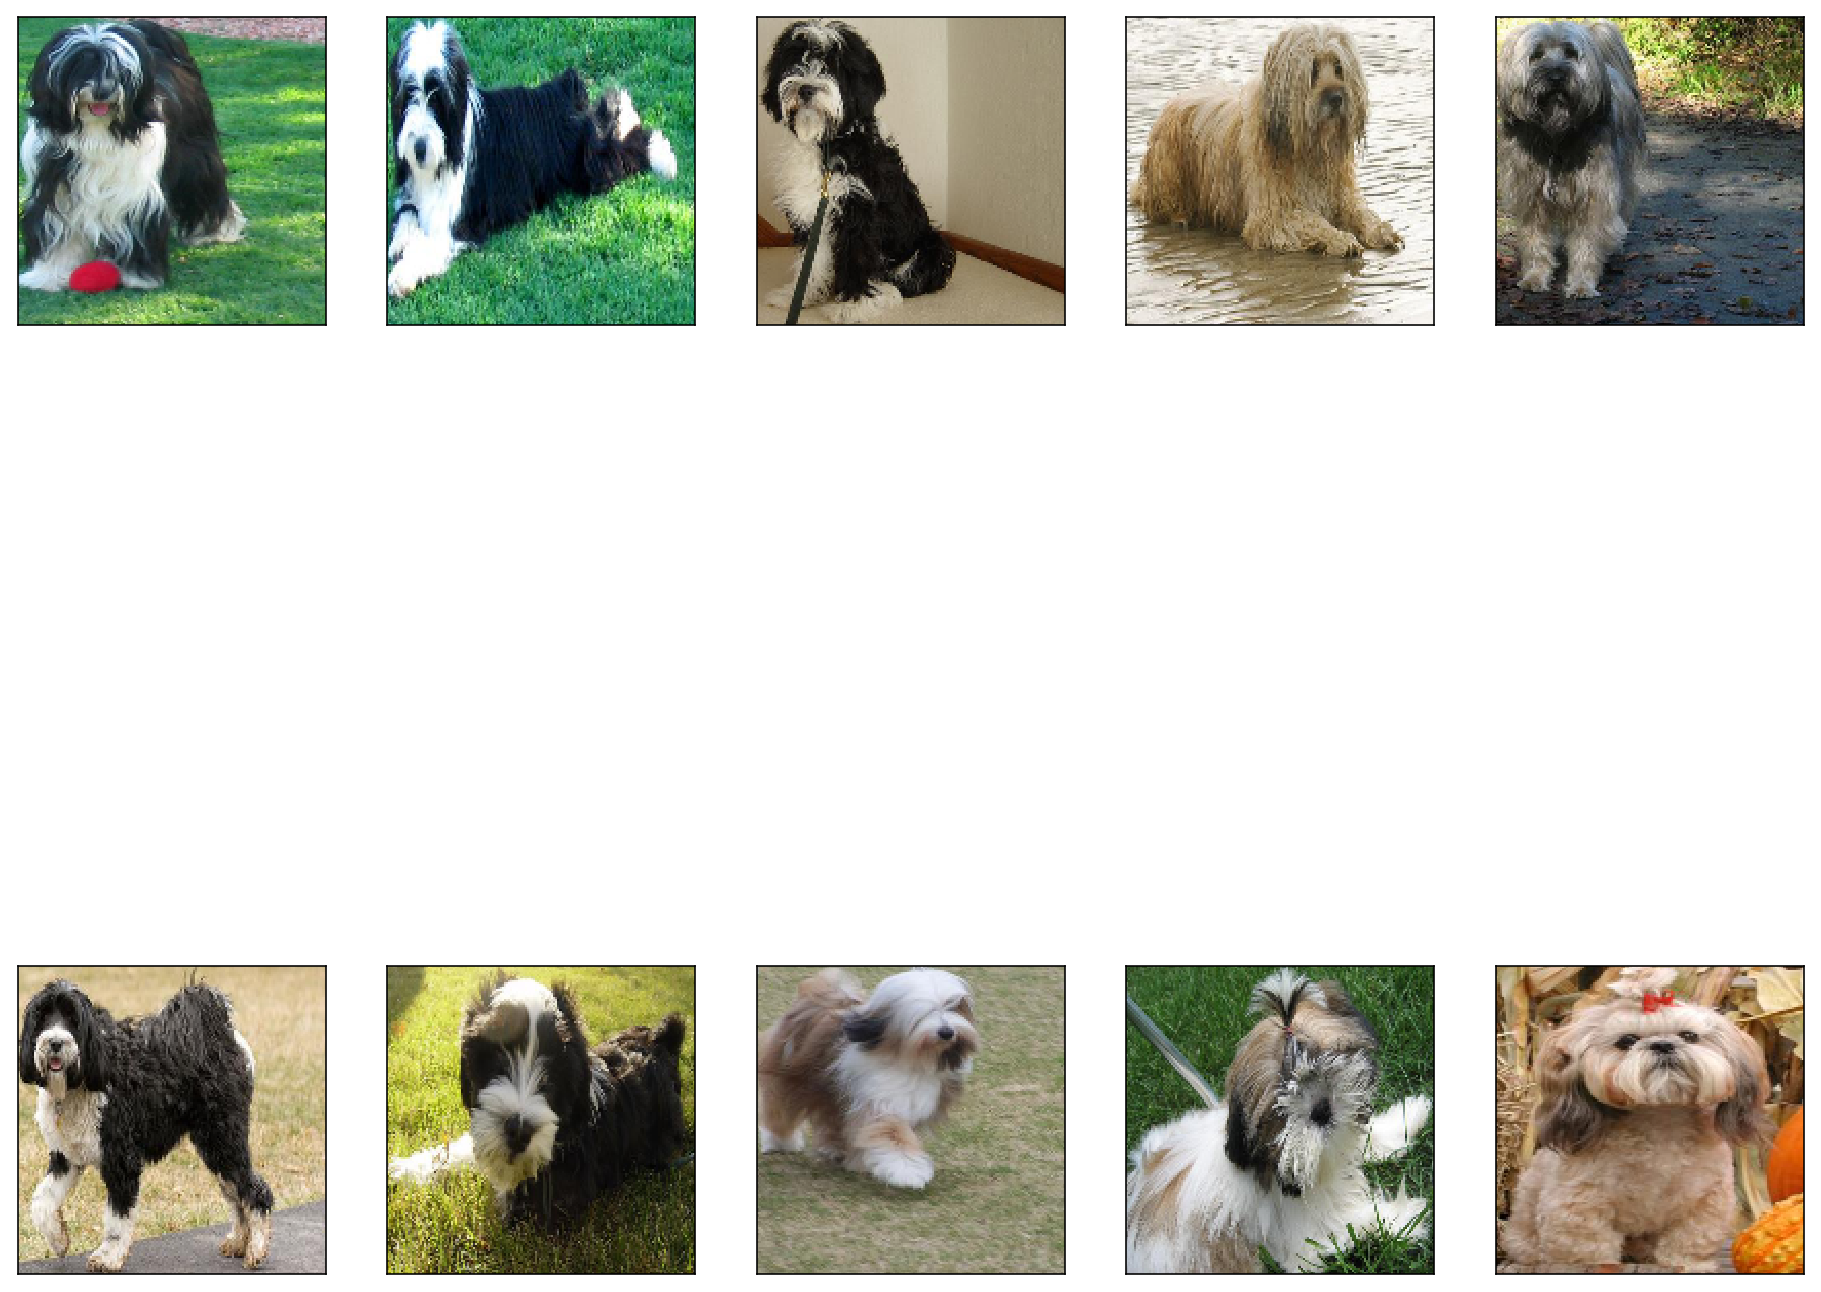

In [12]:
visualize_images(x_train, 150, 10)

# 6. One-hot Encode the labels<a class="anchor" id="6"></a>

In [13]:
y_train = pd.get_dummies(y_train)
y_train = y_train.values
y_train.shape

(22125, 120)

# 6.1 Split the data into test, train and validation sets<a class="anchor" id="6.1"></a>

In [14]:
(x_test, x_valid, x_train) = x_train[:1000], x_train[1001:2000], x_train[2001:]
(y_test, y_valid, y_train) = y_train[:1000], y_train[1001:2000], y_train[2001:]

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

20124 train samples
1000 test samples
999 validation samples


# 7. Normalization<a class="anchor" id="7"></a>
- Since the image is in RCG format, we could downgrade it to grayscale
- We would also change the labels to be int32
- It will be useful when we are categorizing them

In [15]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_valid = x_valid.astype('float32')/255
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
y_valid = y_valid.astype('int32')

In [16]:
x_train.shape
type(y_train)

numpy.ndarray

# 8. Define the VGG-19 model architecture <a class="anchor" id="8"></a>
The CNN model is defined below:

filters - The number of filters. (Helps in extracting different features)

kernel_size - Number specifying both the height and width of the (square) convolution window. There are some additional, optional arguments that you might like to tune:
strides - The stride of the convolution. If you don't specify anything, strides is set to 1.
padding - One of 'valid' or 'same'. If you don't specify anything, padding is set to 'valid'.

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.applications.vgg19 import VGG19,preprocess_input

base_model = VGG19(include_top=False,
                  input_shape = (150,150,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(120,activation='softmax'))
model.summary()

Using TensorFlow backend.


<keras.engine.topology.InputLayer object at 0x7f29e077dc50> False
<keras.layers.convolutional.Conv2D object at 0x7f29e077d940> False
<keras.layers.convolutional.Conv2D object at 0x7f29c7afb400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29c7b13cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f29c7b27ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f29d463c240> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29d52ccb38> False
<keras.layers.convolutional.Conv2D object at 0x7f29d51d3978> False
<keras.layers.convolutional.Conv2D object at 0x7f29d46188d0> False
<keras.layers.convolutional.Conv2D object at 0x7f29d5085748> False
<keras.layers.convolutional.Conv2D object at 0x7f29e28eef60> False
<keras.layers.pooling.MaxPooling2D object at 0x7f29d50289b0> False
<keras.layers.convolutional.Conv2D object at 0x7f29d502af60> False
<keras.layers.convolutional.Conv2D object at 0x7f29d504a940> False
<keras.layers.convolutional.Conv2D object at 0x7f29dfeb8278> Fa

# 9. Compile the Model<a class="anchor" id="9"></a>
Since there are 120 different breed types, we use categorical_crossentropy as loss

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

# 10. Augmenting the Images<a class="anchor" id="10"></a>
- Rotational Invariance = Rotating the images randomly so that CNN can learn those images
- Translation Invariance = Translate the images randomly so that CNN can learn those images
- Augmentation reduces overfitting

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)

# 11. Train the Model<a class="anchor" id="11"></a>

In [ ]:
print("x_train.shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)
print("x_test.shape: ", x_test.shape)
print("y_test.shape: ", y_test.shape)
print("x_valid.shape: ", x_valid.shape)
print("y_valid.shape: ", y_valid.shape)


x_train.shape:  (20124, 150, 150, 3)
y_train.shape:  (20124, 120)
x_test.shape:  (1000, 150, 150, 3)
y_test.shape:  (1000, 120)
x_valid.shape:  (999, 150, 150, 3)
y_valid.shape:  (999, 120)


In [ ]:
from keras.callbacks import ModelCheckpoint   

batch_size = 128 
epochs = 5

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/5


# 12. Load the Model with the Best Validation Accuracy<a class="anchor" id="12"></a>

In [ ]:
model.load_weights('aug_model.weights.best.hdf5')

# 13. Calculate Classification Accuracy on Test Set<a class="anchor" id="13"></a>

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1]*100)